In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *

In [2]:
# read in MASKED Nsat data 

# lowz
data_Nsat_low = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_low-EDR.npz')
Nsat35_low = data_Nsat_low['masked_Nsat_low35']

# midz
data_Nsat_mid = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_mid-EDR.npz')
Nsat35_mid = data_Nsat_mid['masked_Nsat_mid35']
Nsat05_mid = data_Nsat_mid['masked_Nsat_mid05']

# highz
data_Nsat_high = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_high-EDR.npz')
Nsat35_high = data_Nsat_high['masked_Nsat_high35']
Nsat05_high = data_Nsat_high['masked_Nsat_high05']
Nsat65_high = data_Nsat_high['masked_Nsat_high65']



In [3]:
# read in near

data_near = np.load('/Users/mtownsend/Documents/LRG_Data/data_near-EDR.npz')
near_total = data_near['near_total']
near35 = data_near['data_near35']
near05 = data_near['data_near05']
near65 = data_near['data_near65']

print(near35.shape)
print(near05.shape)
print(near65.shape)


# read in Nbkg

data_Nbkg = np.load('/Users/mtownsend/Documents/LRG_Data/data_Nbkg-EDR.npz')
Nbkg_total = data_Nbkg['Nbkg_total']
Nbkg35 = data_Nbkg['data_Nbkg35']
Nbkg05 = data_Nbkg['data_Nbkg05']
Nbkg65 = data_Nbkg['data_Nbkg65']

print(Nbkg_total.shape)
print(Nbkg35.shape)
print(Nbkg05.shape)
print(Nbkg65.shape)


# calculate unmasked Nsat

Nsat05 = near05 - Nbkg05
print(len(Nsat05))


(309, 49, 49, 49)
(617, 49, 49, 49)
(897, 49, 49, 49)
(1823, 49, 49, 49)
(309, 49, 49, 49)
(617, 49, 49, 49)
(897, 49, 49, 49)
617


In [3]:
# edges for function

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

zmaginit = 13.
zmagfin = 23.
interval = 0.2
zmag_num = (zmagfin-zmaginit)/interval
zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
print(type(zmag_edges))

# edges = np.array([rz_edges, zmag_edges, gr_edges])
edges = np.array([rz_edges, gr_edges, zmag_edges])
print(edges.shape)


<class 'numpy.ndarray'>
(3, 50)


In [4]:
# the redshift, rzcolor, and zmag of LRGs

data_zLRG = np.load('/Users/mtownsend/anaconda/Data/z_LRG.npz')
zLRG = data_zLRG['z_LRG']
print(zLRG.shape)

print('----')

data_zmagLRG = np.load('/Users/mtownsend/anaconda/Data/zmag_LRG.npz')
zmagLRG = data_zmagLRG['zmag_LRG']
print(zmagLRG.shape)
print(zmagLRG.min())
print(zmagLRG.max())

print('----')

data_grcolorLRG = np.load('/Users/mtownsend/anaconda/Data/grcolor_LRG.npz')
grcolorLRG = data_grcolorLRG['grcolor_LRG']
print(grcolorLRG.shape)

print('----')

data_rzcolorLRG = np.load('/Users/mtownsend/anaconda/Data/rzcolor_LRG.npz')
rzcolorLRG = data_rzcolorLRG['rzcolor_LRG']
print(rzcolorLRG.shape)




data_raLRG = np.load('/Users/mtownsend/anaconda/Data/ra_LRG.npz')
raLRG = data_raLRG['ra_LRG']
print(raLRG.shape)

print('----')

data_decLRG = np.load('/Users/mtownsend/anaconda/Data/dec_LRG.npz')
decLRG = data_decLRG['dec_LRG']
print(decLRG.shape)




# rzcolor_high05 = rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]
# zmag_high05 = zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]
# print(len(rzcolorLRG_high05))


# ra_high05 = raLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]
# dec_high05 = decLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]

# print(len(ra_high05))

# print(ra_high05[103])
# print(dec_high05[103])
# print()
# print(ra_high05[182])
# print(dec_high05[182])
# print()
# print(ra_high05[318])
# print(dec_high05[318])



(1823,)
----
(1823,)
15.818878
21.957382
----
(1823,)
----
(1823,)
(1823,)
----
(1823,)


In [27]:
arr = np.ones([2,2,2])
arr[0][0][0] = 3
arr[0][1][0] = 0
arr[0][0][1] = 5
arr[0][1][1] = 8

arr[1][0][0] = 1
arr[1][1][0] = 1
arr[1][0][1] = 1
arr[1][1][1] = 1
print(arr)
print(arr.shape)

print(arr[:,:,:].sum(axis=0))

[[[3. 5.]
  [0. 8.]]

 [[1. 1.]
  [1. 1.]]]
(2, 2, 2)
[[4. 6.]
 [1. 9.]]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

print(Nsat35_low.shape)

rz_zmag_sum_low35 = list(np.zeros((49,49)))
for i in range(len(Nsat35_low)):
    arr_sum_low35 = Nsat35_low[i][:, :, :].sum(axis=1)
    rz_zmag_sum_low35 += arr_sum_low35

rz_vs_zmag_low35 = np.flipud(rz_zmag_sum_low35)



rz_zmag_sum_mid35 = list(np.zeros((49,49)))
temp = []
for i in range(len(Nsat35_mid)):
    arr_sum_mid35 = Nsat35_mid[i][:, :, :].sum(axis=1)
    temp.append(arr_sum_mid35)
    rz_zmag_sum_mid35 += arr_sum_mid35

rz_vs_zmag_mid35 = np.flipud(rz_zmag_sum_mid35)

print(len(temp))
print(rz_vs_zmag_mid35.min())
print(rz_vs_zmag_mid35.max())

rz_zmag_sum_mid05 = list(np.zeros((49,49)))
for i in range(len(Nsat05_mid)):
    arr_sum_mid05 = Nsat05_mid[i][:, :, :].sum(axis=1)
    rz_zmag_sum_mid05 += arr_sum_mid05

rz_vs_zmag_mid05 = np.flipud(rz_zmag_sum_mid05)



rz_zmag_sum_high35 = list(np.zeros((49,49)))
for i in range(len(Nsat35_high)):
    arr_sum_high35 = Nsat35_high[i][:, :, :].sum(axis=1)
    rz_zmag_sum_high35 += arr_sum_high35

rz_vs_zmag_high35 = np.flipud(rz_zmag_sum_high35)

rz_zmag_sum_high05 = list(np.zeros((49,49)))
for i in range(len(Nsat05_high)):
    arr_sum_high05 = Nsat05_high[i][:, :, :].sum(axis=1)
    rz_zmag_sum_high05 += arr_sum_high05

rz_vs_zmag_high05 = np.flipud(rz_zmag_sum_high05)

rz_zmag_sum_high65 = list(np.zeros((49,49)))
for i in range(len(Nsat65_high)):
    arr_sum_high65 = Nsat65_high[i][:, :, :].sum(axis=1)
    rz_zmag_sum_high65 += arr_sum_high65

rz_vs_zmag_high65 = np.flipud(rz_zmag_sum_high65)





# rz_zmag_sum_high05 = list(np.zeros((49,49)))
# for i in range(len(Nsat05_high)):
#     arr_sum_high05 = Nsat05_high[i][:, :, :].sum(axis=1)
#     rz_zmag_sum_high05 += arr_sum_high05

# temp0 = Nsat05_high[103][:, :, :].sum(axis=1)
# temp1 = Nsat05_high[182][:, :, :].sum(axis=1)
# temp2 = Nsat05_high[318][:, :, :].sum(axis=1)
# rz_vs_zmag = temp0 + temp1 + temp2
# rz_vs_zmag_test = np.flipud(rz_vs_zmag)



    
    # [103, 182, 318]

# gr_rz_sum_high05 = list(np.zeros((49,49)))
# for i in range(len(Nsat05_high)):
#     gr_arr_sum_high05 = Nsat05_high[i][:, :, :].sum(axis=1)
#     gr_rz_sum_high05 += gr_arr_sum_high05

# gr_vs_rz_high05 = np.flipud(gr_rz_sum_high05.T)


(309, 49, 49, 49)
309
-6.437373222541497
79.24569154533248


In [179]:
print(len(temp))
# print(temp[0].min())
# print(np.argwhere(temp[0] == temp[0].min()))
print(np.argwhere(rz_zmag_sum_mid35 == rz_zmag_sum_mid35.min()))
print(rz_zmag_sum_mid35[9][22])

# print(temp[3][10][23])
# print(temp[3][10][28])

# t = []
# for i in range(len(temp)):
#     t.append(temp[i][10][28])
# #     print(np.argwhere(temp[i] == temp[i].min()))
    
# avg = np.mean(t)
# print(len(t))

309
[[ 9 22]]
-5.415325824352965


In [270]:
# import matplotlib.gridspec as gridspec

# fig, axes = plt.subplots(nrows=2, ncols=2, tight_layout=True) #, figsize=(10,20)) #, sharex=True, sharey=True)

# # gs = gridspec.GridSpec(
# #         nrows=2, ncols=2, left=0.1, bottom=0.05, right=0.95, top=0.95,
# #         wspace=0., hspace=0., width_ratios=[1, 1])

# # axes[0,0] = plt.subplot(gs[0])
# # axes[0,1] = plt.subplot(gs[1])
# # axes[1,0] = plt.subplot(gs[2])
# # axes[1,1] = plt.subplot(gs[3])


# # low
# im1 = axes[0,0].matshow(rz_vs_zmag_low35, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
# axes[0,0].scatter(zmagLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], rzcolorLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], s=4, alpha=0.1, facecolors='none', edgecolors='r', label="LRG; 0.2 > z > 0.35, log(lum)= 9.5")
# axes[0,0].invert_xaxis()
# # plt.tick_params(axis='both', which='major', labelsize=14)
# # plt.xlim(22.36, 16)
# axes[0,0].set_ylim(ymin=-1, ymax=3)
# plt.colorbar(im1, ax=axes[0,0], shrink=1)
# # axes[0,0].colorbar(im1, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# axes[0,0].set_xlabel(r'$z-mag$', fontsize=15)
# axes[0,0].set_ylabel(r'$(r-z)$ $color$', fontsize=15)
# axes[0,0].legend(loc='upper right', prop={'size': 10}, markerscale=5.0)
# axes[0,0].autoscale(False)
# axes[0,1].remove()

# # mid

# im2 = axes[1,0].matshow(rz_vs_zmag_mid35, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
# im3 = axes[1,1].matshow(rz_vs_zmag_mid05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])

# axes[1,0].scatter(zmagLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], rzcolorLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], s=4, alpha=0.1, facecolors='none', edgecolors='r', label="LRG; 0.2 > z > 0.35, log(lum)=9.93")
# axes[1,0].invert_xaxis()
# # plt.tick_params(axis='both', which='major', labelsize=14)
# # plt.xlim(22.36, 16)
# axes[1,0].set_ylim(ymin=-1, ymax=3)
# plt.colorbar(im2, ax=axes[1,0], shrink=1)
# # axes[0,1].colorbar(im2, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# axes[1,0].set_xlabel(r'$z-mag$', fontsize=15)
# axes[1,0].set_ylabel(r'$(r-z)$ $color$', fontsize=15)
# axes[1,0].legend(loc='upper right', prop={'size': 10}, markerscale=5.0)
# axes[1,0].autoscale(False)

# axes[1,1].scatter(zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], s=4, alpha=0.1, facecolors='none', edgecolors='r', label="LRG; 0.35 > z > 0.5, log(lum)=9.93")
# axes[1,1].invert_xaxis()
# # plt.tick_params(axis='both', which='major', labelsize=14)
# # plt.xlim(22.36, 16)
# axes[1,1].set_ylim(ymin=-1, ymax=3)
# # axes[0,2].colorbar(im3, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# plt.colorbar(im3, ax=axes[1,1], shrink=1)
# axes[1,1].set_xlabel(r'$z-mag$', fontsize=15)
# axes[1,1].set_ylabel(r'$(r-z)$ $color$', fontsize=15)
# axes[1,1].legend(loc='upper right', prop={'size': 10}, markerscale=5.0)
# axes[1,1].autoscale(False)

# plt.tight_layout()

# plt.savefig('/Users/mtownsend/Desktop/sat-cmd-test.pdf', bbox_inches='tight')

# plt.show()

In [9]:
rz_zmag_sum_near05 = list(np.zeros((49,49)))
temp = []
for i in range(len(near05)):
    arr_sum_near05 = near05[i][:, :, :].sum(axis=1)
    temp.append(arr_sum_near05)
    rz_zmag_sum_near05 += arr_sum_near05

rz_vs_zmag_near05 = np.flipud(rz_zmag_sum_near05)


rz_zmag_sum_Nbkg05 = list(np.zeros((49,49)))
for i in range(len(Nbkg05)):
    arr_sum_Nbkg05 = Nbkg05[i][:, :, :].sum(axis=1)
    rz_zmag_sum_Nbkg05 += arr_sum_Nbkg05

rz_vs_zmag_Nbkg05 = np.flipud(rz_zmag_sum_Nbkg05)

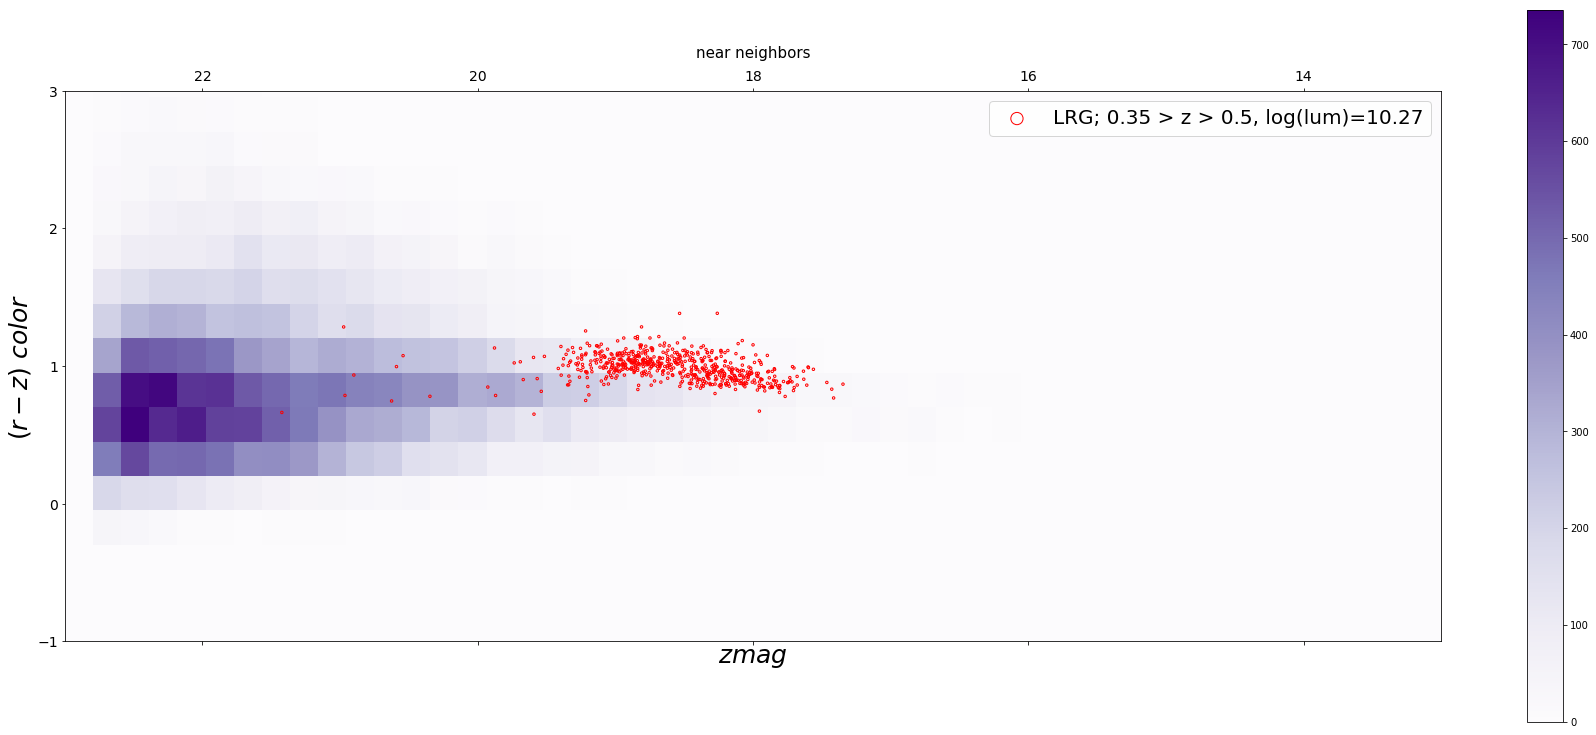

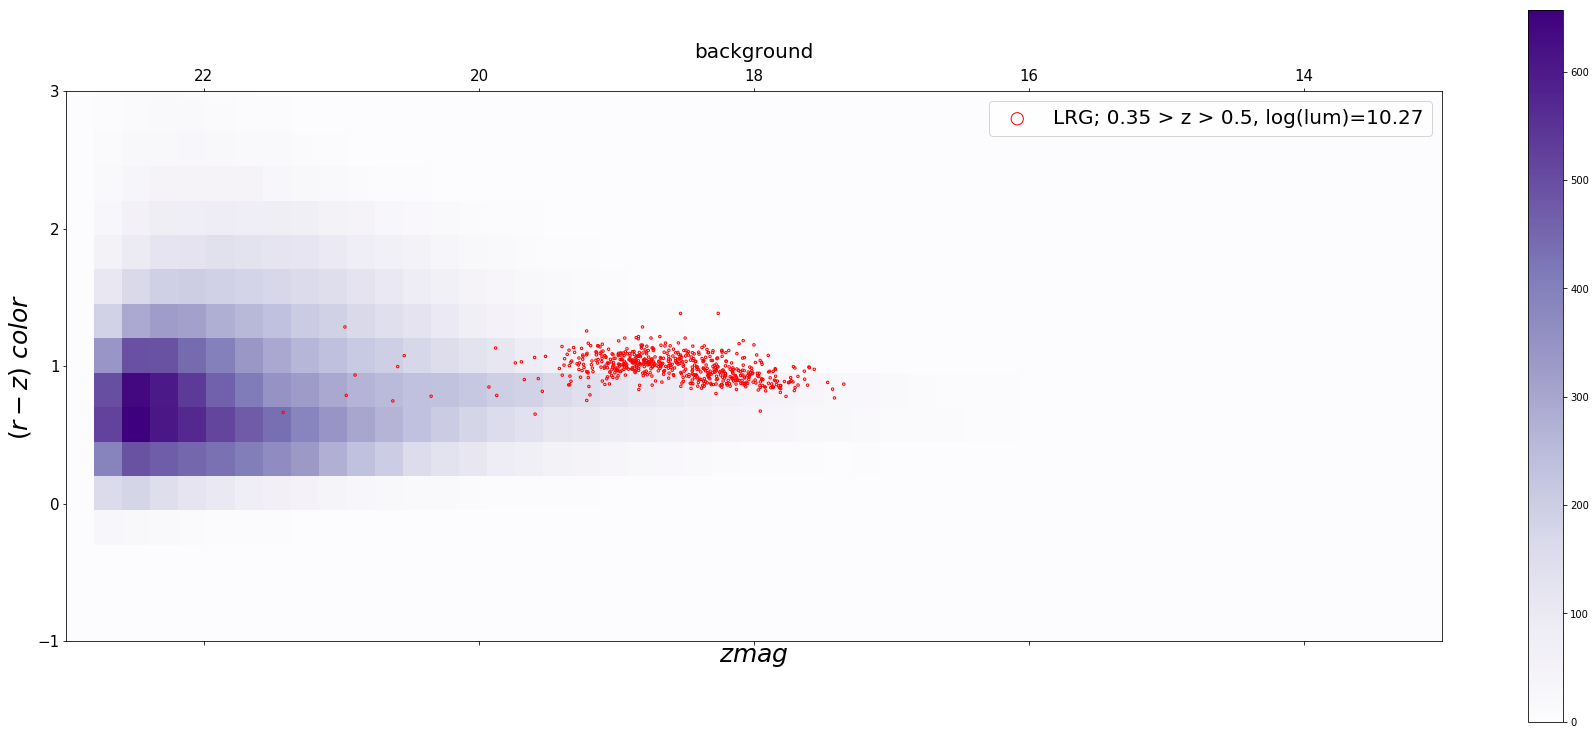

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(25,25)) #, sharex=True, sharey=True)
im5 = axes.matshow(rz_vs_zmag_near05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[0][len(edges[1]) - 1]])
# im5 = axes.matshow(rz_vs_zmag_high05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[1][0], edges[1][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])


axes.scatter(zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], s=6, alpha=1, facecolors='none', edgecolors='r', label="LRG; 0.35 > z > 0.5, log(lum)=10.27")
axes.invert_xaxis()
axes.tick_params(axis='both', which='major', labelsize=14)
# plt.xlim(22.36, 16)
axes.set_ylim(ymin=-1, ymax=3)
axes.set_title("near neighbors", fontsize=15)
# axes[1,1].colorbar(im5, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
plt.colorbar(im5, shrink=0.4)
axes.set_xlabel(r'$zmag$', fontsize=25)
axes.set_ylabel(r'$(r-z)$ $color$', fontsize=25)
axes.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

plt.savefig('/Users/mtownsend/Desktop/near05-cmd.pdf')

plt.show()


fig, axes = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(25,25)) #, sharex=True, sharey=True)
im6 = axes.matshow(rz_vs_zmag_Nbkg05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[0][len(edges[1]) - 1]])
# im5 = axes.matshow(rz_vs_zmag_high05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[1][0], edges[1][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])


axes.scatter(zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], s=6, alpha=1, facecolors='none', edgecolors='r', label="LRG; 0.35 > z > 0.5, log(lum)=10.27")
axes.invert_xaxis()
axes.tick_params(axis='both', which='major', labelsize=15)
# plt.xlim(22.36, 16)
axes.set_ylim(ymin=-1, ymax=3)
axes.set_title("background", fontsize=20)
# axes[1,1].colorbar(im5, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
plt.colorbar(im6, shrink=0.4)
axes.set_xlabel(r'$zmag$', fontsize=25)
axes.set_ylabel(r'$(r-z)$ $color$', fontsize=25)
axes.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

plt.savefig('/Users/mtownsend/Desktop/Nbkg05-cmd.pdf')


plt.show()


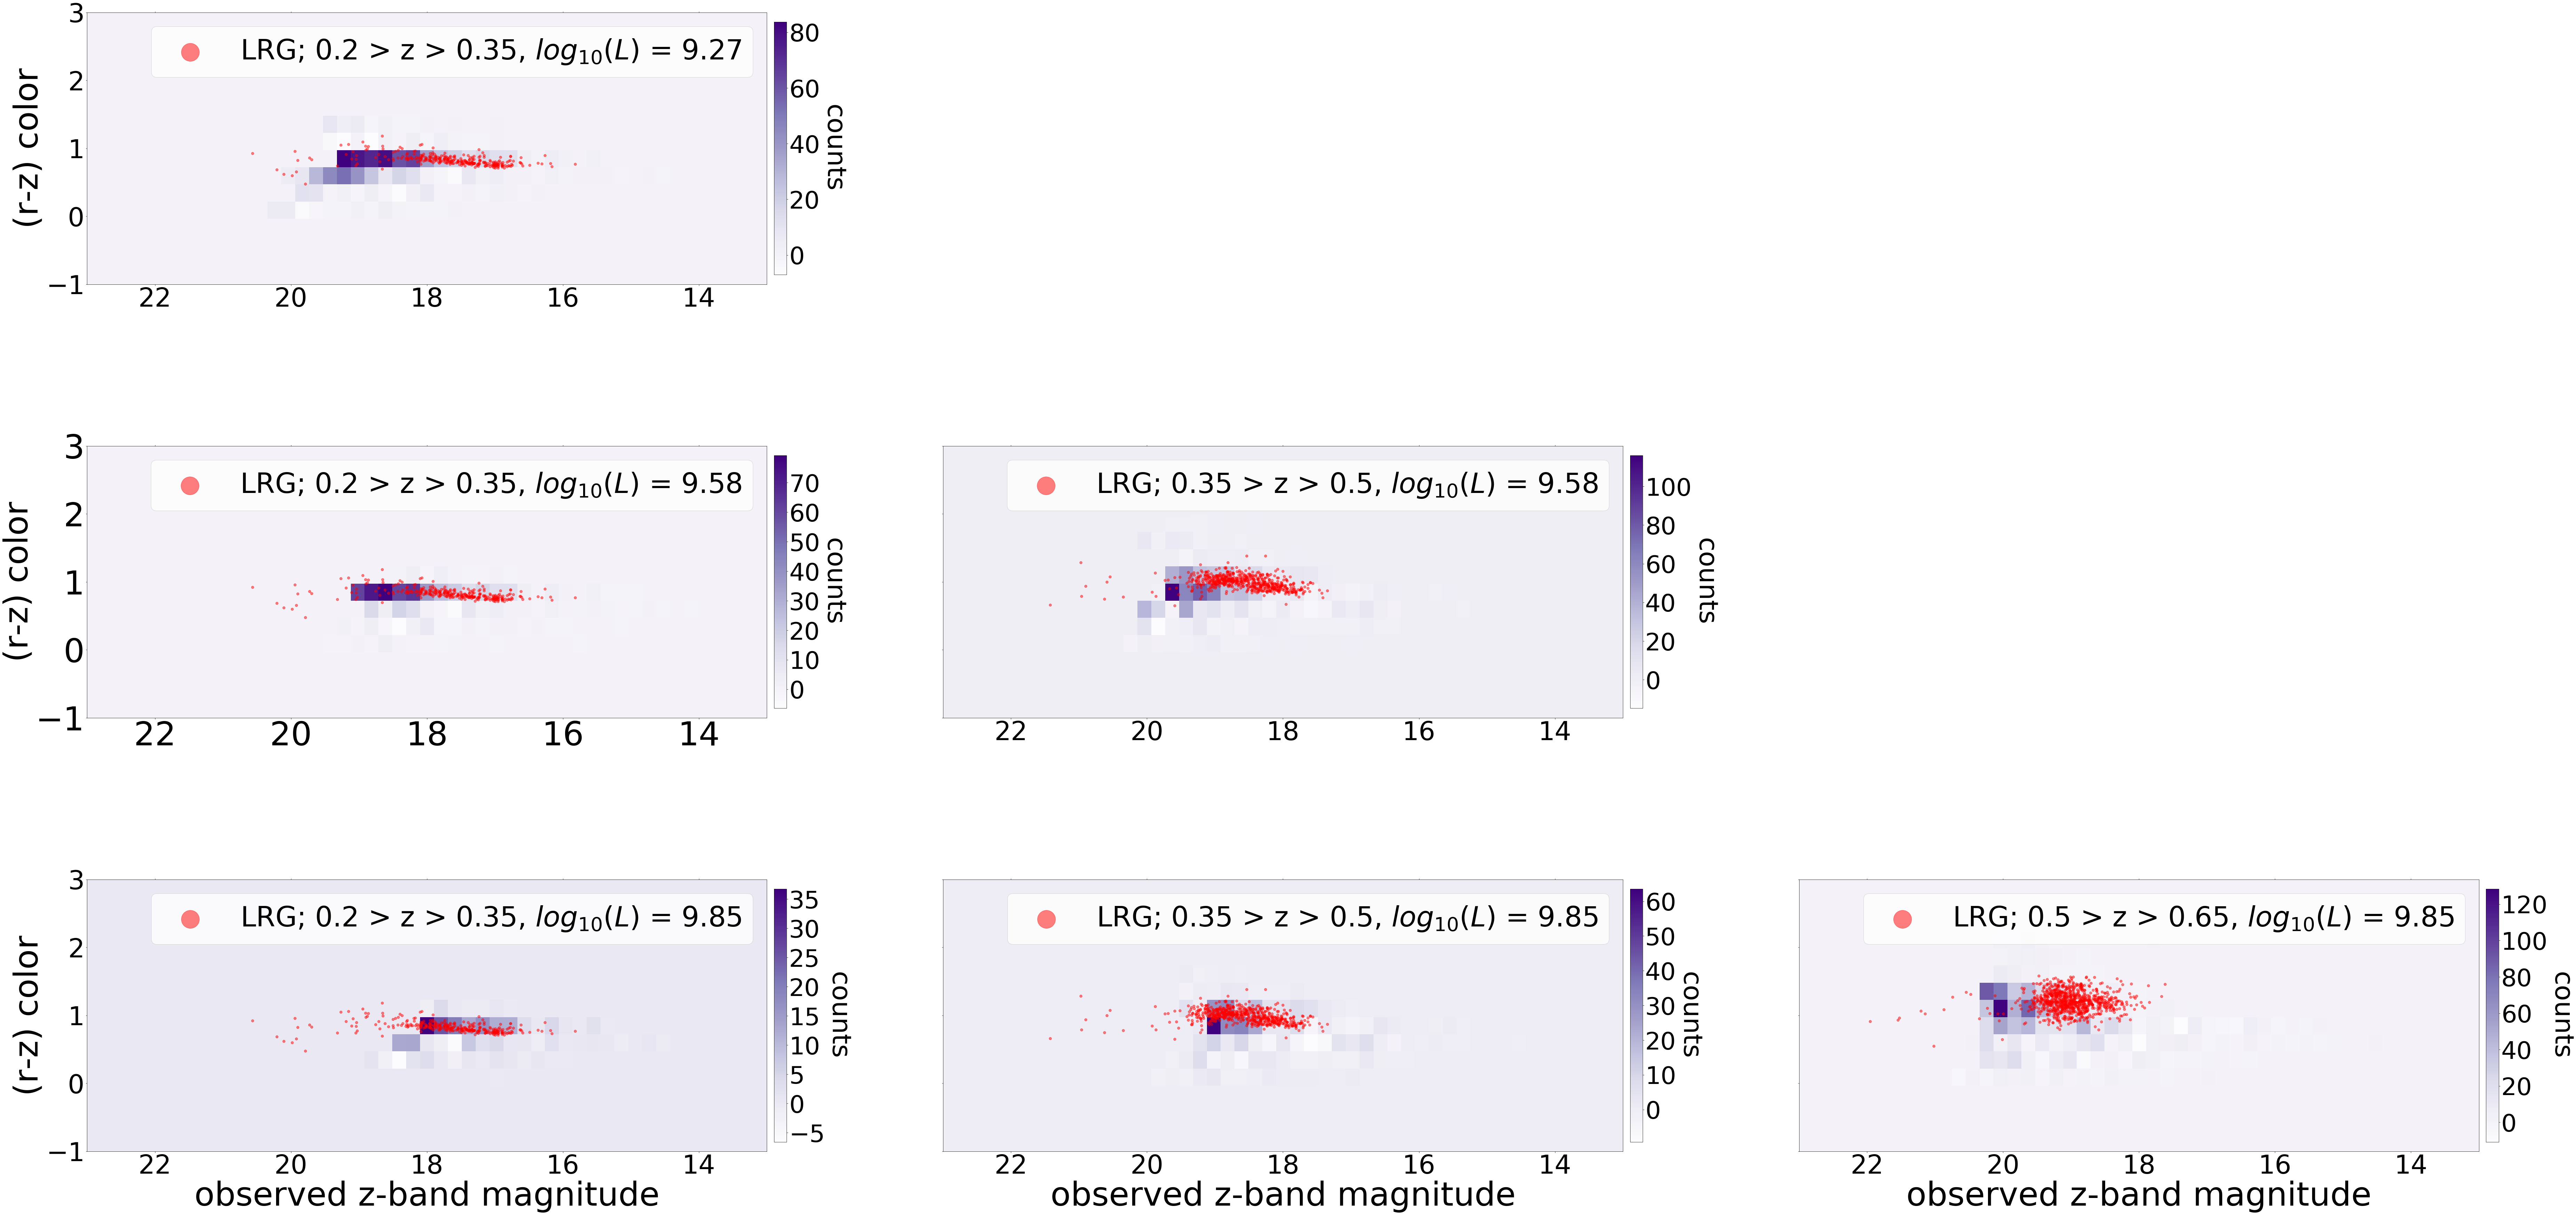

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, tight_layout=False, figsize=(125,65), sharey=True)
# Set whitespace to 0
# fig.subplots_adjust(left=0,right=1,bottom=0,top=1)


# low
im1 = axes[0,0].matshow(rz_vs_zmag_low35, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
axes[0,0].scatter(zmagLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], rzcolorLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.2 > z > 0.35, $log_{10}(L)$ = 9.27")
axes[0,0].invert_xaxis()
axes[0,0].tick_params(labelbottom=True, labeltop=False, labelsize=75)
# plt.xlim(22.36, 16)
axes[0,0].set_ylim(ymin=-1, ymax=3)
# plt.colorbar(im1, ax=axes[0,0], shrink=0.5, label='counts', labelsize=15)
cb1 = fig.colorbar(im1, ax=axes[0,0], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb1.set_label(label='counts', fontsize=75, rotation=270)
cb1.ax.tick_params(labelsize=70)
cb1.ax.get_yaxis().labelpad = 75
# axes[0,0].set_xlabel('observed z-band magnitude', fontsize=75)
axes[0,0].set_ylabel('(r-z) color', fontsize=95)
axes[0,0].legend(loc='upper right', fontsize='80', markerscale=7.0)
axes[0,1].remove()
axes[0,2].remove()

# mid

im2 = axes[1,0].matshow(rz_vs_zmag_mid35, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
im3 = axes[1,1].matshow(rz_vs_zmag_mid05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])

axes[1,0].scatter(zmagLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], rzcolorLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.2 > z > 0.35, $log_{10}(L)$ = 9.58")
axes[1,0].invert_xaxis()
axes[1,0].tick_params(labelbottom=True, labeltop=False, labelsize=95)# plt.xlim(22.36, 16)
axes[1,0].set_ylim(ymin=-1, ymax=3)
# plt.colorbar(im2, ax=axes[1,0], shrink=0.5)
cb2 = fig.colorbar(im2, ax=axes[1,0], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb2.set_label(label='counts', fontsize=75, rotation=270)
cb2.ax.tick_params(labelsize=70)
cb2.ax.get_yaxis().labelpad = 75
# axes[1,0].set_xlabel('observed z-band magnitude', fontsize=75)
axes[1,0].set_ylabel('(r-z) color', fontsize=95)
axes[1,0].legend(loc='upper right', fontsize='80', markerscale=7.0)

axes[1,1].scatter(zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.35 > z > 0.5, $log_{10}(L)$ = 9.58")
axes[1,1].invert_xaxis()
axes[1,1].tick_params(labelbottom=True, labeltop=False, labelsize=75)# plt.xlim(22.36, 16)
axes[1,1].set_ylim(ymin=-1, ymax=3)
# axes[0,2].colorbar(im3, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# plt.colorbar(im3, ax=axes[1,1], shrink=0.5)
cb3 = fig.colorbar(im3, ax=axes[1,1], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb3.set_label(label='counts', fontsize=75, rotation=270)
cb3.ax.tick_params(labelsize=70)
cb3.ax.get_yaxis().labelpad = 75
# axes[1,1].set_xlabel('observed z-band magnitude', fontsize=75)
# axes[1,1].set_ylabel(r'$(r-z)$ $color$', fontsize=35)
axes[1,1].legend(loc='upper right', fontsize='80', markerscale=7.0)
axes[1,2].remove()

# high

im4 = axes[2,0].matshow(rz_vs_zmag_high35, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
im5 = axes[2,1].matshow(rz_vs_zmag_high05, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])
im6 = axes[2,2].matshow(rz_vs_zmag_high65, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[2][0], edges[2][len(edges[0]) - 1], edges[0][0], edges[1][len(edges[1]) - 1]])


axes[2,0].scatter(zmagLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], rzcolorLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.2 > z > 0.35, $log_{10}(L)$ = 9.85")
axes[2,0].invert_xaxis()
axes[2,0].tick_params(labelbottom=True, labeltop=False, labelsize=75)# plt.xlim(22.36, 16)
axes[2,0].set_ylim(ymin=-1, ymax=3)
# axes[1,0].colorbar(im4, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# plt.colorbar(im4, ax=axes[2,0], shrink=0.5)
cb4 = fig.colorbar(im4, ax=axes[2,0], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb4.set_label(label='counts', fontsize=75, rotation=270)
cb4.ax.tick_params(labelsize=70)
cb4.ax.get_yaxis().labelpad = 75
axes[2,0].set_xlabel('observed z-band magnitude', fontsize=95)
axes[2,0].set_ylabel('(r-z) color', fontsize=95)
axes[2,0].legend(loc='upper right', fontsize='80', markerscale=7.0)

axes[2,1].scatter(zmagLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], rzcolorLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.35 > z > 0.5, $log_{10}(L)$ = 9.85")
axes[2,1].invert_xaxis()
axes[2,1].tick_params(labelbottom=True, labeltop=False, labelsize=75)# plt.xlim(22.36, 16)
axes[2,1].set_ylim(ymin=-1, ymax=3)
# axes[1,1].colorbar(im5, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# plt.colorbar(im5, ax=axes[2,1], shrink=0.5)
cb5 = fig.colorbar(im5, ax=axes[2,1], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb5.set_label(label='counts', fontsize=75, rotation=270)
cb5.ax.tick_params(labelsize=70)
cb5.ax.get_yaxis().labelpad = 75
axes[2,1].set_xlabel('observed z-band magnitude', fontsize=95)
# axes[2,1].set_ylabel(r'$(r-z)$ $color$', fontsize=35)
axes[2,1].legend(loc='upper right', fontsize='80', markerscale=7.0)


axes[2,2].scatter(zmagLRG[np.where((zLRG >= 0.5) & (zLRG < 0.65))], rzcolorLRG[np.where((zLRG >= 0.5) & (zLRG < 0.65))], s=55, alpha=0.5, facecolors='r', edgecolors='r', label="LRG; 0.5 > z > 0.65, $log_{10}(L)$ = 9.85")
axes[2,2].invert_xaxis()
axes[2,2].tick_params(labelbottom=True, labeltop=False, labelsize=75)# plt.xlim(22.36, 16)
axes[2,2].set_ylim(ymin=-1, ymax=3)
# axes[2,0].colorbar(im4, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.4)
# plt.colorbar(im6, ax=axes[2,2], shrink=0.5)
cb6 = fig.colorbar(im6, ax=axes[2,2], orientation="vertical", fraction=0.037, pad=0.01, shrink=0.7)
cb6.set_label(label='counts', fontsize=75, rotation=270)
cb6.ax.tick_params(labelsize=70)
cb6.ax.get_yaxis().labelpad = 75
axes[2,2].set_xlabel('observed z-band magnitude', fontsize=95)
# axes[2,2].set_ylabel(r'$(r-z)$ $color$', fontsize=35)
axes[2,2].legend(loc='upper right', fontsize='80', markerscale=7.0)


# fig.tight_layout(h_pad=1)
# plt.subplots_adjust(hspace=0.001)

plt.savefig('/Users/mtownsend/Desktop/PaperPlots/sat-cmds-all-v5.pdf')

plt.show()


In [32]:
def cmdHistograms(H, edges, zmag_LRG, z_LRG, rzcolor_LRG):

    # This function plots a color-magnitude 2D histogram for satellites around LRG; produces a histogram for every LRG

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors

    plt.rcParams.update({'figure.max_open_warning': 0})

    rz_zmag_sum = list(np.zeros((49,49)))
#     gr_zmag_sum = list(np.zeros((49,49)))
#     gr_rz_sum = list(np.zeros((49,49)))
    for i in range(len(H)):
        # make 2D projections of 3D histogram
        rz_v_zmag = H[i][:, :, :].sum(axis=2)
        rz_vs_zmag = np.flipud(rz_v_zmag)
        rz_zmag_sum = np.add(rz_zmag_sum, rz_vs_zmag)
#         gr_v_zmag = H[i][:, :, :].sum(axis=0)
#         gr_vs_zmag = np.flipud(gr_v_zmag.T)
#         gr_zmag_sum = np.add(gr_zmag_sum, gr_vs_zmag)
#         gr_v_rz = H[i][:, :, :].sum(axis=1)
#         gr_vs_rz = np.flipud(gr_v_rz.T)
#         gr_rz_sum = np.add(gr_rz_sum, gr_vs_rz)
        

        # plot 2D histograms using matshow; 3 plots per image
#         f, axarr = plt.subplots(111, figsize=(10, 10))
#         f.suptitle("Satellite Density CMD (LRG {})".format(i))

    plt.rcParams["figure.figsize"] = [40, 10]
    im1 = plt.matshow(rz_zmag_sum, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[1][0], edges[1][len(edges[1]) - 1], edges[0][0], edges[0][len(edges[0]) - 1]])
    plt.scatter(zmag_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], rzcolor_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], s=4, color='red', label="LRG; 0.5 > z > 0.65")
#     plt.title("Satellite Color-Magnitude Diagram (0.2 > z > 0.35)".format(i), fontsize=20, pad=20)
#     plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#     plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    plt.gca().invert_xaxis()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlim(22.36, 16)
    plt.ylim(-1, 3)
    plt.colorbar(im1, orientation="vertical", fraction=0.037, pad=0.07, label='counts', shrink=0.6)
    plt.xlabel(r'$z-mag$', fontsize=15)
    plt.ylabel(r'$(r-z)$ $color$', fontsize=15)
    plt.legend(loc='upper right', prop={'size': 15}, markerscale=5.0)

        # save image with incrementing file name
#     plt.savefig('/Users/mtownsend/Desktop/PaperPlots/sats_cmd_high65.pdf')    
    plt.show()
    
# cmdHistograms(Nsat_zcut1, edges)
# cmdHistograms(Nsat_zcut2, edges)
# cmdHistograms(Nsat_zcut3, edges)
# cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# sns.jointplot(Nsat_zcut5, edges, kind="hex", color="#4CB391")


In [37]:
# lowz_Nsat = lowz_maskedNsat25 + lowz_maskedNsat03
# print(np.asarray(lowz_maskedNsat25).shape)
# print(np.asarray(lowz_maskedNsat03).shape)
# print(np.asarray(lowz_Nsat).shape)

# mid1_Nsat = mid1_maskedNsat25 + mid1_maskedNsat03 + mid1_maskedNsat35 + mid1_maskedNsat04

# mid2_Nsat = mid2_maskedNsat25 + mid2_maskedNsat03 + mid2_maskedNsat35 + mid2_maskedNsat04 + mid2_maskedNsat45 + mid2_maskedNsat05

# mid3_Nsat = mid3_maskedNsat25 + mid3_maskedNsat03 + mid3_maskedNsat35 + mid3_maskedNsat04 + mid3_maskedNsat45 + mid3_maskedNsat05 + mid3_maskedNsat55 + mid3_maskedNsat06

# high_Nsat = high_maskedNsat25 + high_maskedNsat03 + high_maskedNsat35 + high_maskedNsat04 + high_maskedNsat45 + high_maskedNsat05 + high_maskedNsat55 + high_maskedNsat06 + high_maskedNsat65



(90, 49, 49, 49)
(83, 49, 49, 49)
(173, 49, 49, 49)


No handles with labels found to put in legend.


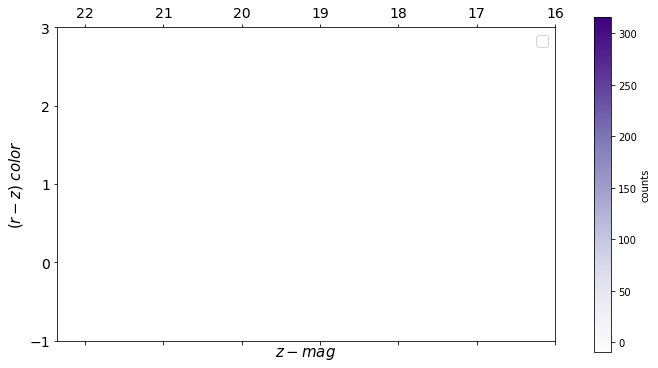

In [33]:
cmdHistograms(Nsat35_low, edges, zmagLRG, zLRG, rzcolorLRG)


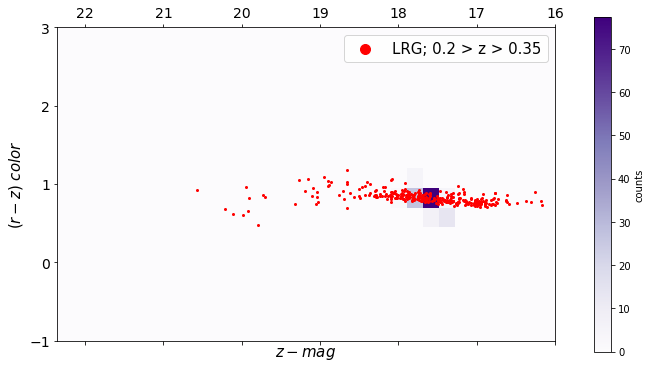

In [51]:
cmdHistograms(Nsat35_mid, edges, zmagLRG, zLRG, rzcolorLRG)


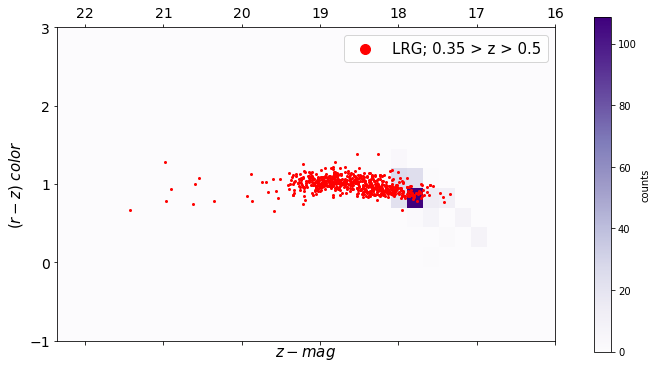

In [55]:
cmdHistograms(Nsat05_mid, edges, zmagLRG, zLRG, rzcolorLRG)


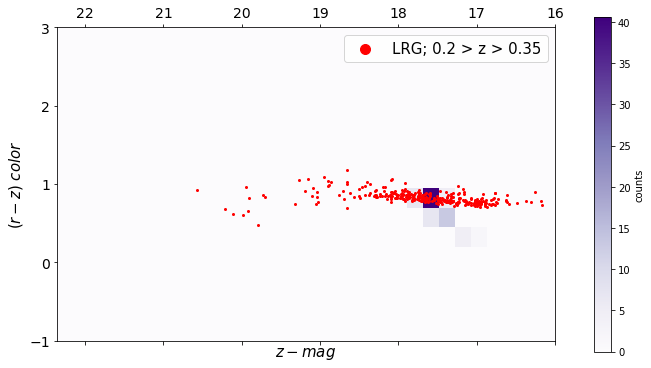

In [57]:
cmdHistograms(Nsat35_high, edges, zmagLRG, zLRG, rzcolorLRG)


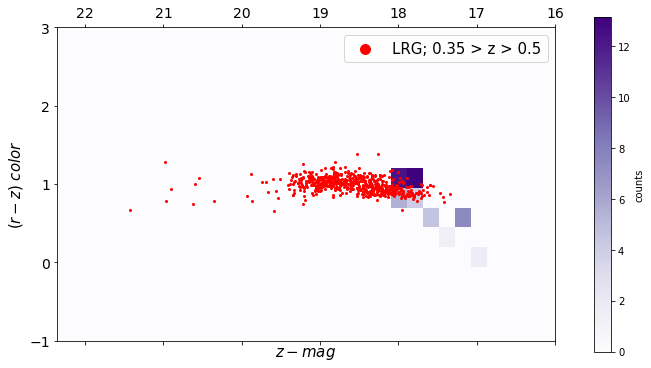

In [59]:
cmdHistograms(Nsat05_high, edges, zmagLRG, zLRG, rzcolorLRG)


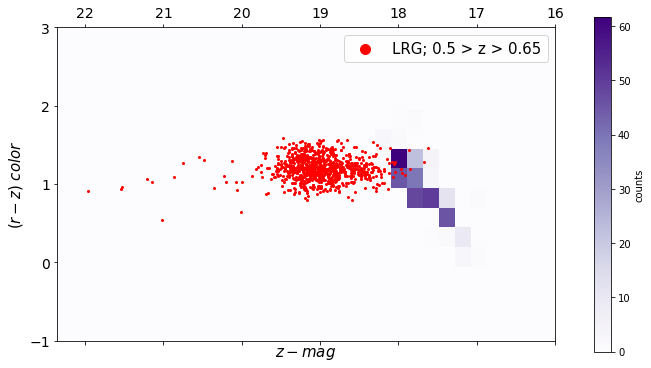

In [61]:
cmdHistograms(Nsat65_high, edges, zmagLRG, zLRG, rzcolorLRG)
